# Movie Recommendation System

<img src="https://www.plex.tv/wp-content/uploads/2025/03/Watch-Free-Hero-2048x1152-1.png">

## 🎯 Project Objective
The objective of this project is to design and implement a lightweight and effective movie recommendation system using the MovieLens 100K dataset.  
The system aims to generate personalized movie recommendations based on user–item interaction patterns while keeping the model size small and efficient for easy deployment on platforms such as Hugging Face.


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [2]:
x = Path("/kaggle/input/movielens-100k-dataset/ml-100k")

## 🔍 Exploratory Data Analysis (EDA)
Exploratory Data Analysis is conducted to understand the structure and characteristics of the dataset.  
Key analyses include:
- Distribution of user ratings
- Identification of the most active users and most rated movies
- Detection of missing values
- Evaluation of dataset sparsity and rating bias

These insights guide the data preprocessing and modeling decisions.

In [3]:
ratings = pd.read_csv(
    x / "u.data",
    sep="\t",
    names=["user_id", "item_id", "rating", "timestamp"])

In [4]:
movies = pd.read_csv(
    x / "u.item",
    sep="|",
    encoding="latin-1",
    header=None)

In [5]:
movies.columns = [
    "item_id", "title", "release_date", "video_release_date", "imdb_url",
    "unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [6]:
users = pd.read_csv(
    x / "u.user",
    sep="|",
    names=["user_id", "age", "gender", "occupation", "zip_code"])

## 📊 Dataset Description
The MovieLens 100K dataset is a widely used benchmark dataset for recommendation systems.  
It contains:
- 100,000 ratings
- 943 users
- 1,682 movies

Each rating consists of a user ID, a movie ID, a rating score (1–5), and a timestamp.  
Additional metadata includes movie titles, release dates, genres, and basic user demographics.

In [34]:
users.shape

(943, 5)

In [35]:
movies.shape

(1682, 23)

In [36]:
ratings.shape

(100000, 4)

In [7]:
ratings.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [8]:
movies.isna().sum().head()

item_id                  0
title                    0
release_date             1
video_release_date    1682
imdb_url                 3
dtype: int64

In [17]:
movies = movies.drop(columns=["video_release_date"])

In [9]:
users.isna().sum()

user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64

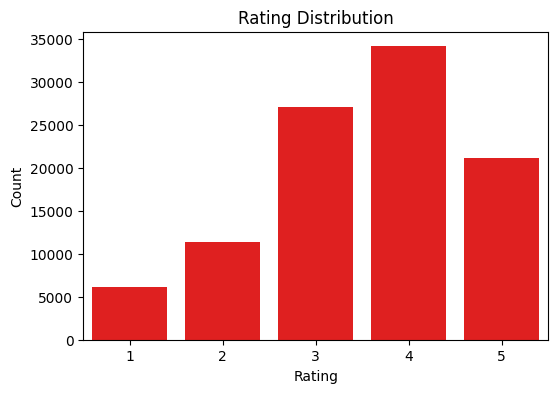

In [11]:
plt.figure(figsize=(6,4))
sns.countplot(data=ratings, x="rating", color="red")
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

/tmp/ipykernel_55/3335603345.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="summer")


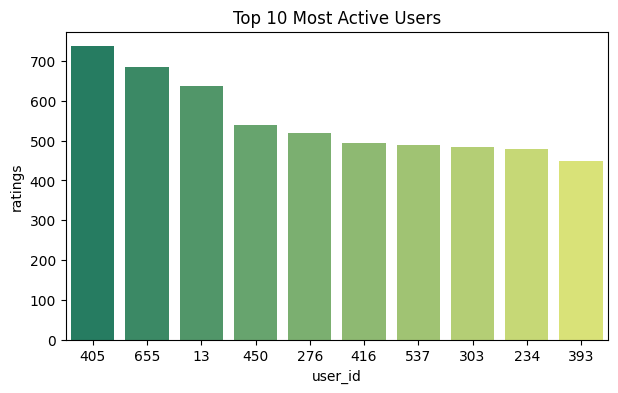

In [16]:
top_users = ratings["user_id"].value_counts().head(10)

plt.figure(figsize=(7,4))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette="summer")
plt.title("Top 10 Most Active Users")
plt.xlabel("user_id")
plt.ylabel("ratings")
plt.show()

/tmp/ipykernel_55/1960496960.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.index.astype(str), y=top_movies.values, palette="winter")


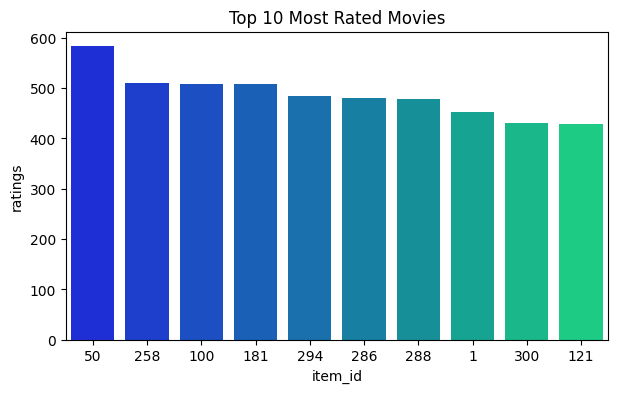

In [15]:
top_movies = ratings["item_id"].value_counts().head(10)

plt.figure(figsize=(7,4))
sns.barplot(x=top_movies.index.astype(str), y=top_movies.values, palette="winter")
plt.title("Top 10 Most Rated Movies")
plt.xlabel("item_id")
plt.ylabel("ratings")
plt.show()

## 🧹 Data Preprocessing
Data preprocessing steps are applied to ensure clean and model-ready inputs:
- Removal of irrelevant or highly missing columns
- Handling of missing values
- Data type normalization
- Deduplication of user–item interactions
- Construction of user–item matrices for collaborative filtering

Optional filtering is applied to reduce noise from extremely inactive users or rarely rated items.

In [18]:
ratings = ratings.drop_duplicates(
    subset=["user_id", "item_id", "timestamp"]).copy()

In [19]:
ratings["user_id"] = ratings["user_id"].astype(int)
ratings["item_id"] = ratings["item_id"].astype(int)
ratings["rating"] = ratings["rating"].astype(int)
ratings["timestamp"] = ratings["timestamp"].astype(int)

In [20]:
global_mean = ratings["rating"].mean()

In [21]:
n_users = ratings["user_id"].nunique()
n_items = ratings["item_id"].nunique()
n_ratings = len(ratings)

sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"Users      : {n_users}")
print(f"Items      : {n_items}")
print(f"Ratings    : {n_ratings}")
print(f"Sparsity   : {sparsity:.4f}")

Users      : 943
Items      : 1682
Ratings    : 100000
Sparsity   : 0.9370


In [22]:
ratings_processed = ratings.merge(
    movies[["item_id", "title"]],
    on="item_id",
    how="left")

In [23]:
ratings_processed.head()

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [24]:
min_ratings = 20

active_users = ratings_processed["user_id"].value_counts()
popular_movies = ratings_processed["item_id"].value_counts()

ratings_processed = ratings_processed[
    ratings_processed["user_id"].isin(active_users[active_users >= min_ratings].index)
    & ratings_processed["item_id"].isin(popular_movies[popular_movies >= min_ratings].index)]

## 🤖 Model Training
An item-based collaborative filtering approach is used to model user preferences.  
Cosine similarity is computed between item vectors, and only the top-K most similar items for each movie are retained.  

This approach allows:
- Fast inference without retraining
- Minimal model storage size
- Efficient recommendation generation suitable for lightweight deployment

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

In [26]:
ui = ratings.pivot_table(index="user_id", columns="item_id", values="rating")
ui_centered = ui.sub(ui.mean(axis=1), axis=0).fillna(0)
item_matrix = ui_centered.T.values
sim = cosine_similarity(item_matrix)
item_ids = ui_centered.columns.to_numpy()

In [27]:
k = 50
topk = {}
for i, item in enumerate(item_ids):
    s = sim[i].copy()
    s[i] = -1  
    idx = np.argpartition(s, -k)[-k:]
    idx = idx[np.argsort(s[idx])[::-1]]
    topk[int(item)] = [(int(item_ids[j]), float(s[j])) for j in idx if s[j] > 0]

In [28]:
id2title = dict(zip(movies["item_id"].astype(int), movies["title"]))

In [29]:
user_ratings = ratings.groupby("user_id").apply(
    lambda d: dict(zip(d["item_id"].astype(int), d["rating"].astype(float)))).to_dict()

/tmp/ipykernel_55/18111136.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_ratings = ratings.groupby("user_id").apply(


In [30]:

def recommend(user_id: int, n: int = 10):
    seen = user_ratings.get(user_id, {})
    if len(seen) == 0:
        return []

    scores = {}
    weights = {}

    for item, r in seen.items():
        for nb, w in topk.get(item, []):
            if nb in seen:
                continue
            scores[nb] = scores.get(nb, 0.0) + w * (r - 3.0)  # baseline 3
            weights[nb] = weights.get(nb, 0.0) + abs(w)

    ranked = sorted(
        ((i, scores[i] / weights[i]) for i in scores if weights[i] > 0),
        key=lambda x: x[1],
        reverse=True
    )[:n]

    return [(i, id2title.get(i, "Unknown"), float(s)) for i, s in ranked]

In [31]:
recommend(405, 10)

[(333, 'Game, The (1997)', 2.0),
 (1654, 'Chairman of the Board (1998)', 2.0),
 (1199, 'Cemetery Man (Dellamorte Dellamore) (1994)', 1.0),
 (270, 'Gattaca (1997)', 1.0),
 (1483, 'Man in the Iron Mask, The (1998)', 1.0),
 (345, 'Deconstructing Harry (1997)', 1.0),
 (903, 'Afterglow (1997)', 1.0),
 (750, 'Amistad (1997)', 1.0),
 (300, 'Air Force One (1997)', 1.0),
 (925, 'Unforgettable (1996)', 0.8052812032753488)]

In [32]:
import pickle

artifact = {
    "topk": topk,
    "id2title": id2title,
    "k": k}

with open("movielens100k_itemcf_topk.pkl", "wb") as f:
    pickle.dump(artifact, f)

import os
os.path.getsize("movielens100k_itemcf_topk.pkl") / (1024*1024)

1.1661739349365234